In [130]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats import truncnorm
import xml.dom.minidom
import xml.etree.ElementTree as gfg
def my_colormap(x,y,z,axs,fig,title='pcolormesh'):
    
# y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

# z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
# x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
#     z = z[:-1, :-1]
#     z_min, z_max = np.abs(z).min(), np.abs(z).max()
    # z_min, z_max = 0.00064, 0.048
    z_min, z_max = np.min(z+0.00001), np.max(z+0.00001)

    # print(np.min(z), np.max(z))
    # c=axs.pcolor(x, y, z,norm=colors.LogNorm(vmin=z_min, vmax=z_max),cmap='RdBu')
    c = axs.pcolor(x, y, z, cmap='Blues', vmin=z_min, vmax=z_max)
    axs.set_title(title)
    # set the limits of the plot to the limits of the data
    axs.axis([x.min(), x.max(), y.min(), y.max()])
    fig.colorbar(c, ax=axs)
    return('sup')


def append_object(root,label="NAME",pose="Unspecified",truncated="0",dificult="0",xmin="0",ymin="0",xmax="0",ymax="0"):
    m4 = gfg.Element("object") 
    root.append(m4)
    c1 = gfg.SubElement(m4, "name") 
    c1.text = label
    c2 = gfg.SubElement(m4, "pose") 
    c2.text = pose
    c3 = gfg.SubElement(m4, "truncated") 
    c3.text = truncated
    c4 = gfg.SubElement(m4, "dificult") 
    c4.text = dificult
    c5 = gfg.Element("bndbox") 
    m4.append(c5)

    d1 = gfg.SubElement(c5, "xmin") 
    d1.text = xmin
    d2 = gfg.SubElement(c5, "ymin") 
    d2.text = ymin
    d3 = gfg.SubElement(c5, "xmax") 
    d3.text = xmax
    d4 = gfg.SubElement(c5, "ymax") 
    d4.text = ymax

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd).rvs()

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def rotate_2D(x,y,angle=np.pi/4):
    xy = np.array([x,y])
    c ,s = np.cos(angle), np.sin(angle)
    R = np.array(((c, -s), (s, c)))
    rot = np.dot(R,xy)
    return rot[0],rot[1]

class defect:
    # constructor
    def __init__(self,thickness=0.2,resolution=100,r=1,center=(0,0),color=0.8):
        cmap = cm.get_cmap('afmhot')
        rgb=cmap(color)
        self.center=center
        self.color=rgb
        self.fraction = 1
        self.resolution = resolution
        self.thickness = thickness
        self.theta = np.linspace(0, 2*np.pi*self.fraction, self.resolution)
        self.r = r
        self.x1 = self.r*np.cos(self.theta)+center[0] 
        self.y1 = self.r*np.sin(self.theta)+center[1]

        self.x2 = (self.r-self.thickness)*np.cos(self.theta) +center[0]
        self.y2 = (self.r-self.thickness)*np.sin(self.theta) +center[1]
    def plot(self):
        fig, ax = plt.subplots(1)
        ax.scatter(self.x1, self.y1)
        ax.scatter(self.x2, self.y2)
        ax.set_aspect(1)
        plt.grid(linestyle='--')
        plt.show()
   
    def add_bump(self,mu=0,sigma=2,lumpyness=-1):
        #top = int(self.resolution/2) # apply only to the first half
        top_1 = np.where(self.y1 >= 0)
        top_2 = np.where(self.y2 >= 0)
        #plt.plot(self.x1[top_1],self.y1[top_1])
        
        gauss_y1 = gaussian(self.x1[top_1],mu,sigma)
        gauss_y2 = gaussian(self.x2[top_2],mu,sigma)
        
        #plt.plot(x1[top_1],gauss_y1-np.min(gauss_y1))
        #plt.plot(x2[top_2],- lumpyness *(gauss_y2-np.min(gauss_y2)))
        
        self.y1[top_1] = self.y1[top_1] + gauss_y1-np.min(gauss_y1)
        self.y2[top_2] = self.y2[top_2] - lumpyness *(gauss_y2-np.min(gauss_y2)) #+ np.max(y2)
        
    
    def rotate(self,angle=np.pi/4):
        self.x1, self.y1 = rotate_2D(self.x1-self.center[0],self.y1-self.center[1],angle=angle)
        self.x2, self.y2 = rotate_2D(self.x2-self.center[0],self.y2-self.center[1],angle=angle)
        self.x1, self.y1 =self.x1+self.center[0], self.y1+self.center[1]
        self.x2, self.y2 =self.x2+self.center[0], self.y2+self.center[1]


    def cut(self,fraction=1/2):
        angle = fraction*2*np.pi
        self.fraction=fraction
#         split = np.where( np.arctan2(self.y1,self.x1)+np.pi < angle ) # kazkaip cia gustai per sudetingai sugalvojai
        split= np.where(self.theta<angle) #pakeiciau nes kitai neveike kai defekto centras ne (0,0)
        self.x1, self.y1 = self.x1[split], self.y1[split]
        self.x2, self.y2 = self.x2[split], self.y2[split]
     
    # need some work
    def fill(self,axs,cutoff=0.2):
        if self.fraction<1:
            axs.set_aspect(1)
#             right_bound = [ print(i,np.abs(self.x1[i]-self.x1[i-1]), np.abs(self.x1[i-1]-self.x1[i-2])) for i,x in enumerate(self.x1) if np.abs(self.x1[i]                 -self.x1[i-1]) > cutoff * np.abs(self.x1[i-1]-self.x1[i-2]) ]
#             right_bound = [ i for i,x in enumerate(self.x1) if np.abs(self.x1[i]-self.x1[i-1]) > 0.1 + np.abs(self.x1[i-1]-self.x1[i-2]) ]

#             left_bound = int(right_bound[0]-1)
            axs.plot(self.x1,self.y1,color=self.color)
            axs.plot(self.x2,self.y2,color=self.color)
            pair_r = ([self.x1[0],self.x2[0]],[self.y1[0],self.y2[0]])#([self.x1[right_bound],self.x2[right_bound]],[self.y1[right_bound],self.y2[right_bound]])
            # plt.plot(pair[0],pair[1])
            pair_l = ([self.x1[-1],self.x2[-1]],[self.y1[-1],self.y2[-1]])#([self.x1[left_bound],self.x2[left_bound]],[self.y1[left_bound],self.y2[left_bound]])
            # plt.plot(pair[0],pair[1])
            r_l=np.sqrt((pair_l[0][0]-np.average(pair_l[0]))**2+(pair_l[1][0]-np.average(pair_l[1]))**2)
            r_r=np.sqrt((pair_r[0][0]-np.average(pair_r[0]))**2+(pair_r[1][0]-np.average(pair_r[1]))**2)

            Circle1=plt.Circle((np.average(pair_l[0]),np.average(pair_l[1])),r_l,color=self.color)
            Circle2=plt.Circle((np.average(pair_r[0]),np.average(pair_r[1])),r_r,color=self.color)
            axs.add_artist(Circle1)
            axs.add_artist(Circle2)
            # plt.show()

            xs=np.array([self.x1,self.x2])
            ys=np.array([self.y1,self.y2])
            xs[0,:] = xs[0,::-1]
            ys[0,:] = ys[0,::-1]
            axs.fill(np.ravel(xs), np.ravel(ys),color=self.color, edgecolor=self.color)
#             axs.scatter(self.x1[0],self.y1[0],color='black')
#             axs.scatter(self.x1[-1],self.y1[-1],color='orange')
#             axs.scatter(self.x2[0],self.y2[0],color='black')
#             axs.scatter(self.x2[-1],self.y2[-1],color='orange')
        else:
            print('Full circle')
            axs.plot(self.x1, self.y1,color='red')
            axs.plot(self.x2, self.y2,color='red')
            axs.set_aspect(1)
            xs=np.array([self.x1,self.x2])
            ys=np.array([self.y1,self.y2])
            xs[0,:] = xs[0,::-1]
            ys[0,:] = ys[0,::-1]
            axs.fill(np.ravel(xs), np.ravel(ys),color=self.color, edgecolor=self.color)
#             plt.grid(linestyle='--')
#             plt.show()
   
    def get_csv(self,path='contour.csv'):
        self.x = np.concatenate((self.x1,self.x2))
        self.y = np.concatenate((self.y1,self.y2))
        d = {'x': self.x, 'y': self.y}
        df = pd.DataFrame(data=d)
        df.to_csv(path, index=False,sep=" ")
        #print(len(self.x))
        #print(df)
#     def fill2(self):
#         thickness2= np.sqrt((self.x1-self.x2)**2 + (self.y1-self.y2)**2)
#         x1q0=x1[np.where(self.theta<=0.5*np.pi)]
#         x1q1=x1[np.where(self.theta>0.5*np.pi and self.theta <= 1*np.pi)]
#         x1q2=x1[np.where(self.theta>1*np.pi and self.theta <= 1.5*np.pi)]
#         x1q3=x1[np.where(self.theta>1.5*np.pi and self.theta <= 2*np.pi)]

#         x2q0=x2[np.where(self.theta<=0.5*np.pi)]
#         x2q1=x2[np.where(self.theta>0.5*np.pi and self.theta <= 1*np.pi)]
#         x2q2=x2[np.where(self.theta>1*np.pi and self.theta <= 1.5*np.pi)]
#         x2q3=x2[np.where(self.theta>1.5*np.pi and self.theta <= 2*np.pi)]

#         y1q0=y1[np.where(self.theta<=0.5*np.pi)]
#         y1q1=y1[np.where(self.theta>0.5*np.pi and self.theta <= 1*np.pi)]
#         y1q2=y1[np.where(self.theta>1*np.pi and self.theta <= 1.5*np.pi)]
#         y1q3=y1[np.where(self.theta>1.5*np.pi and self.theta <= 2*np.pi)]

#         y2q0=y2[np.where(self.theta<=0.5*np.pi)]
#         y2q1=y2[np.where(self.theta>0.5*np.pi and self.theta <= 1*np.pi)]
#         y2q2=y2[np.where(self.theta>1*np.pi and self.theta <= 1.5*np.pi)]
#         y2q3=y2[np.where(self.theta>1.5*np.pi and self.theta <= 2*np.pi)]


        
        
#   # Geting random shape



In [99]:
# d = defect(center=(1,1))
# for i in range(10):
cmap = cm.get_cmap('afmhot')
x=np.linspace(0.2,1,10)
rgb=cmap(x)
fig ,axs = plt.subplots(1,1)
axs.set_xlim((-10.5,10.5))
axs.set_ylim((-10.5,10.5))
for i in range(10):
    center=np.random.random(2)*10
    print(center,'center')
    cut_angle=np.random.random(1)*0.8+0.2
    d = defect(r=0.5,center=center)
    sigma = get_truncated_normal(mean=3, sd=1, low=0.01, upp=1000)
    # print(sigma)
    lumpyness = get_truncated_normal(mean=-1, sd=1, low=-1, upp=5)
    angle = np.random.normal(np.pi/4,4)
    d.add_bump(sigma=sigma,lumpyness=lumpyness)
    d.cut(cut_angle)
    d.rotate(angle=angle)
    d.fill(axs)
# plt.axis('off')
axs.spines['left'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.tick_params(which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
axs.set_facecolor(rgb[0])

plt.show()

fig.savefig(r"fname2.jpg", dpi=72)

[1.01137249 4.68168089] center


TypeError: can only concatenate tuple (not "list") to tuple

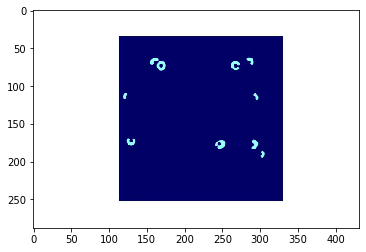

True

In [100]:
#  conda install -c conda-forge opencv 
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('fname2.jpg')
blur = cv2.blur(img,(3,3))

# plt.subplot(121),plt.imshow(img),plt.title('Original')
# plt.xticks([]), plt.yticks([])
# plt.subplot(122),plt.imshow(blur),plt.title('Blurred')
# plt.xticks([]), plt.yticks([])
# plt.show()

# cv2.imshow('sample image',blur)


plt.imshow(img)
plt.show()
cv2.imwrite('fname2_blure.jpg',blur)


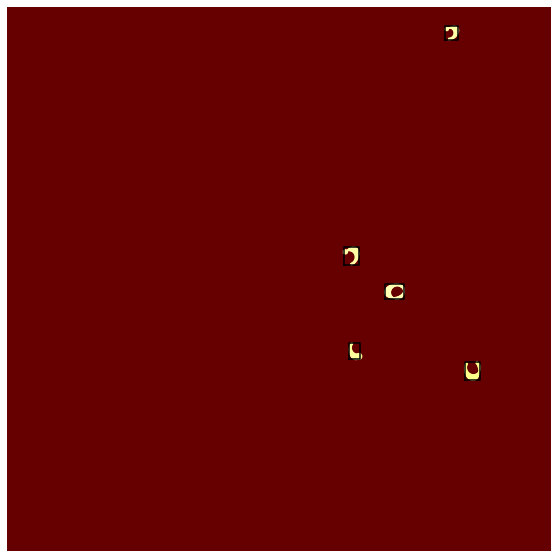

In [140]:

class label_generator(defect):
    def __init__(self,Nr=10,scale=2,radius=30,thickness=10,defect_color=0.8):
        '''Nr - number of defects, scale - size of immage in micrometer, radius - defect radius in nm, thickness in nm '''
        self.Nr=Nr
        self.scale=scale
        self.defect_color=defect_color
        def scale_radius_and_thickness(scale,radius,thickness): 
            '''scale = [micor m], radius=[ nm ]'''
            r_visable=radius/1000
            visable_thickness=thickness/1000/scale
            return r_visable,visable_thickness
        r,th = scale_radius_and_thickness(scale,radius,thickness)
        self.radius=r
        self.thickness=th
    def color(self,color_map_string='afmhot'):
        cmap = cm.get_cmap(color_map_string)
        rgb=cmap(self.defect_color)
        return rgb
    def get_coordinates(self):
        x=np.random.random_sample(self.Nr)*self.scale
        y=np.random.random_sample(self.Nr)*self.scale
        pairs=np.transpose(np.array([x,y]))
        return pairs
    def get_radii(self,dev=0.1):
        array=np.random.normal(loc=self.radius,scale=dev*self.radius,size=self.Nr)
        return(array)
    def get_thicknesses(self,dev=0.1):
        array=np.random.normal(loc=self.thickness,scale=dev*self.thickness,size=self.Nr)
        return(array)
    def get_cut_angle(self):
        array=(1-0.3)*np.random.random_sample(self.Nr)+0.3
        return array
    def get_box(self):
        self.box=[0,scale,0,scale]
        return self.box
    def get_depth(self,dev=0.05,color_map_string='afmhot'):
        # cmap = cm.get_cmap(color_map_string)
        colors = np.random.normal(loc=self.defect_color,scale=dev*self.defect_color,size=self.Nr)
        # rgbs = np.transpose(np.delete(np.transpose(rgbs),3,0))
        return colors
    def get_sigma_lumpyness(self,dev=0.1):
        sigma = get_truncated_normal(mean=3, sd=1, low=0.01, upp=1000)
        lumpyness = get_truncated_normal(mean=-1, sd=1, low=-1, upp=5)
        array_s=np.random.normal(loc=sigma,scale=dev*sigma,size=self.Nr)
        array_l=np.random.normal(loc=lumpyness,scale=abs(dev*lumpyness),size=self.Nr)
        return array_s,array_l

    def generate_immage_with_boxes(self,axs):
        self.radii=self.get_radii()
        self.thicknesses=self.get_thicknesses()
        self.cut_angles=self.get_cut_angle()
        self.sigma,self.lumpyness = self.get_sigma_lumpyness()
        self.colors=self.get_depth()
        self.centers=self.get_coordinates()
        self.box=np.zeros((self.Nr,4))
        for i in range(self.Nr):
            r=self.radii[i]
            thickness=self.thicknesses[i]
            color=self.colors[i]
            center=self.centers[i]
            d = defect(r=self.radii[i],center=self.centers[i],thickness=self.thickness,color=self.colors[i])
            d.add_bump(sigma=self.sigma[i],lumpyness=self.lumpyness[i])
            d.cut(self.cut_angles[i])
            d.rotate(angle=np.random.random()*np.pi*2)
            d.fill(axs)
            # plt.axis('off')
            axs.spines['left'].set_visible(False)
            axs.spines['right'].set_visible(False)
            axs.spines['bottom'].set_visible(False)
            axs.spines['top'].set_visible(False)
            axs.tick_params(which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
            xmin=np.min(np.array([d.x1,d.x2]))
            xmax=np.max(np.array([d.x1,d.x2]))
            ymin=np.min(np.array([d.y1,d.y2]))
            ymax=np.max(np.array([d.y1,d.y2]))
            self.box[i]=np.array([xmin,ymin,xmax,ymax])
            plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],color='black')

    def get_labels(self):
        radii=self.get_radii()
        thicknesses=self.get_thicknesses()
        cut_angles=self.get_cut_angle()
        cut_angles_4=np.abs(cut_angles-1/4)
        cut_angles_3=np.abs(cut_angles-0.5)
        cut_angles_2=np.abs(cut_angles-3/4)
        cut_angles_1=np.abs(cut_angles-1)
        cut_angles_global=np.array([cut_angles_4,cut_angles_3,cut_angles_2,cut_angles_1])
        cut_angles_global_t=np.transpose(cut_angles_global)
        fourth=np.where(cut_angles_global[0]==cut_angles_global_t.min(1))
        half=np.where(cut_angles_global[1]==cut_angles_global_t.min(1))
        three_forths=np.where(cut_angles_global[2]==cut_angles_global_t.min(1))
        full=np.where(cut_angles_global[3]==cut_angles_global_t.min(1))
        cut_angle_labels=np.zeros(self.Nr)
        cut_angle_labels[fourth]=0.25
        cut_angle_labels[half]=0.5
        cut_angle_labels[three_forths]=0.75
        cut_angle_labels[full]=1
        self.fraction=cut_angle_labels
        dict = {'radii': radii, 'thicknesses': thicknesses, 'fraction': cut_angle_labels,'box' : self.box}
        
        return dict
    def get_labels2(self,image_name='test'):
        fileName= image_name+".xml"
        root = gfg.Element("annotation") 
            
        m1 = gfg.Element("folder") 
        m1.text = "training images"
        root.append(m1) 
        m2 = gfg.Element("filename") 
        m2.text = "filename.jpg"
        root.append(m2)

        m3 = gfg.Element("path") 
        m3.text = "PATH"
        root.append(m3)

        m3 = gfg.Element("source") 
        root.append(m3)

        b1 = gfg.SubElement(m3, "database") 
        b1.text = "Unknown"

        m4 = gfg.Element("size")
        root.append(m4)

        b2 = gfg.SubElement(m4, "with") 
        b2.text = "512"
        b3 = gfg.SubElement(m4, "height") 
        b3.text = "512"
        b4 = gfg.SubElement(m4, "depth") 
        b4.text = "3"

        m5 = gfg.Element("segmented")
        m5.text = "0"
        root.append(m5)

        for i in range(self.Nr):
            append_object(root,label=str(self.fraction[i]),xmin=str(self.box[i][0]),ymin=str(self.box[i][1]),xmax=str(self.box[i][2]),ymax=str(self.box[i][3]))

        tree = gfg.ElementTree(root) 

        with open (fileName, "wb") as files : 
            print(fileName)
            tree.write(files) 


        dom = xml.dom.minidom.parse(fileName) # or xml.dom.minidom.parseString(xml_string)
        pretty_xml_as_string = dom.toprettyxml()
        print(pretty_xml_as_string)
    # def het_thickness(Nr,dev,thickness_avg):

    # def depth(Nr,dev,color_avg=0.8):

    # def get_labels():
    #     ''' image path, cut_angle_4_labels'''

r=label_generator(Nr=5)
# a=r.get_radii()
# b=r.get_labels()
# print(b)

fig ,axs = plt.subplots(1,1,figsize=(10,10))
axs.set_xlim((0,2))
axs.set_ylim((0,2))
r.generate_immage_with_boxes(axs)
r.get_labels()
axs.set_facecolor(rgb[0])
plt.show()


In [141]:
a=r.get_labels2()
print(a)

test.xml
<?xml version="1.0" ?>
<annotation>
	<folder>training images</folder>
	<filename>filename.jpg</filename>
	<path>PATH</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<with>512</with>
		<height>512</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>0.25</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<dificult>0</dificult>
		<bndbox>
			<xmin>1.611612380969812</xmin>
			<ymin>1.8802125200331037</ymin>
			<xmax>1.660400060146918</xmax>
			<ymax>1.9297440229658014</ymax>
		</bndbox>
	</object>
	<object>
		<name>0.25</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<dificult>0</dificult>
		<bndbox>
			<xmin>1.6835429699937423</xmin>
			<ymin>0.6276782603628843</ymin>
			<xmax>1.7405478221310464</xmax>
			<ymax>0.6956155494181148</ymax>
		</bndbox>
	</object>
	<object>
		<name>0.75</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<dificult>0</dificult>
		<bndbox>
			<xmin>1.389865467178689<

In [142]:
!pwd

/tmp/dcda7018-027d-4e41-81c4-85375bb636d4
